In [83]:
import numpy as np
from scipy.stats import distributions as iid
from scipy.stats import rv_continuous, norm
import plotly.graph_objects as go
from scipy.integrate import quad

## Exercise 3

In [68]:
# generate continous variable and discrete variable
# continuous variable
x1 = iid.norm()
x2 = iid.norm(loc=1,scale=2)

# discrete variable
Omega1 = (-1,0,1)
Omega2 = (-0.5,0,2)
Pr = (1/4.,1/4.,1/2.)

s1 = iid.rv_discrete(values=(Omega1,Pr))
s2 = iid.rv_discrete(values=(Omega2,Pr))

#### Question 2

In [50]:
# define the class 
class ConvolvedDiscrete(iid.rv_discrete):
    """
    Class to convolve two discrete random variables.
    """
    def __init__(self, s1, s2):
        self.discrete_rv1 = s1
        self.discrete_rv2 = s2
        super(ConvolvedDiscrete, self).__init__(name="ConvolvedDiscrete")
        
    def _pdf(self, z):
        f = 0
        s1 = self.discrete_rv1
        s2 = self.discrete_rv2
        
        for k1 in range(len(s1.xk)):
            for k2 in range(len(s2.xk)):
                if z==s1.xk[k1]+s2.xk[k2]:
                    f = f + s1.pk[k1]*s2.pk[k2]
        return f
        
    def _cdf(self, z):
        F = 0
        s1 = self.discrete_rv1
        s2 = self.discrete_rv2
        
        for k1 in range(len(s1.xk)):
            for k2 in range(len(s2.xk)):
                if z>=s1.xk[k1]+s2.xk[k2]:
                    F = F + s1.pk[k1]*s2.pk[k2]
        return F

s = ConvolvedDiscrete(s1,s2)

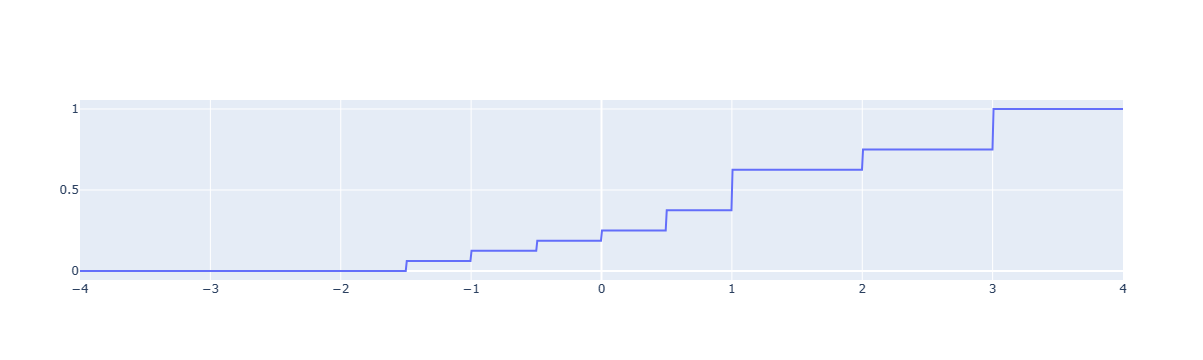

In [53]:
# plot the cdf
X = np.linspace(-4,4,1000).tolist() # sample point
fig = go.Figure(data=go.Scatter(x=X, y=[s._cdf(z) for z in X]))
fig.show()

#### Question 3
It would be hard if we use the same method as before since it's continuous, also its time complexity would be too high if we use looping.</br>
Hence we'll try to use kernel density estimation here.

In [117]:
class ConvolvedContinuous(iid.rv_continuous):

    """
    Class to convolve two continuous random variables.
    """

    def __init__(self,f1,f2):
        self.continuous_rv1 = f1
        self.continuous_rv2 = f2
        
        self.k = lambda u:np.exp(-(u**2)/2)/np.sqrt(2*np.pi) # We use guassian since it's smooth
        
        self.sample1 = f1.rvs(1000) # get the sample from f1
        self.sample2 = f2.rvs(1000) # get the sample from f2
        self.sample = self.sample1[:,np.newaxis] + self.sample2[np.newaxis,:] # use broadcast feature to get the sample of new variable
        self.sample = self.sample.reshape(-1)[:10000] # resample to reduce the time complexity for cdf
        
        self.h = self.sample.std()*self.sample.shape[0]**(-1/5)*1.06 # use Silverman rule of thumb to get the optimal bandwidth
        self.density = lambda x:self.k((x-self.sample)/self.h).mean()/self.h # estimate pdf
        
        
        super(ConvolvedContinuous, self).__init__(name="ConvolvedContinuous")
        
    def _pdf(self,z):
        density = self.density
        return density(z)
        

    def _cdf(self,z):
        density = self.density
        sample = self.sample
        c_density = lambda u: quad(density,min(sample),u)
        return c_density(z)[0]
    
x = ConvolvedContinuous(x1,x2)

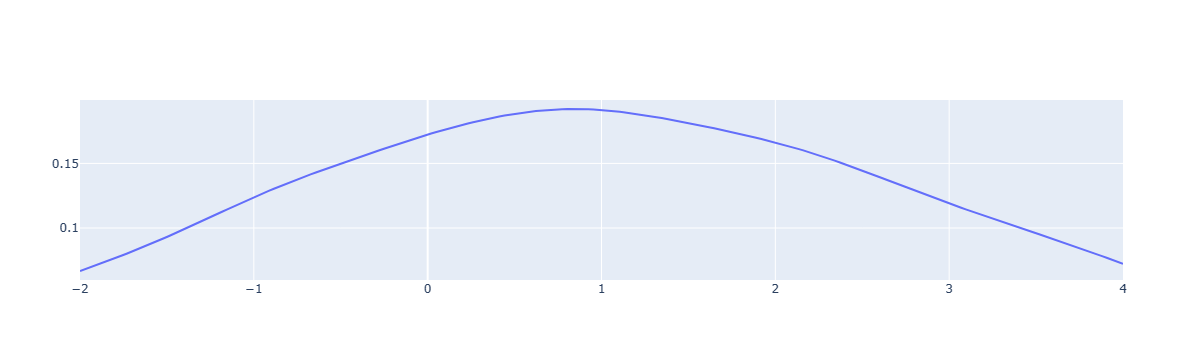

In [118]:
# plot the pdf
X = np.linspace(-2,4,200).tolist() # sample point
fig = go.Figure(data=go.Scatter(x=X, y=[x._pdf(z) for z in X]))
fig.show()

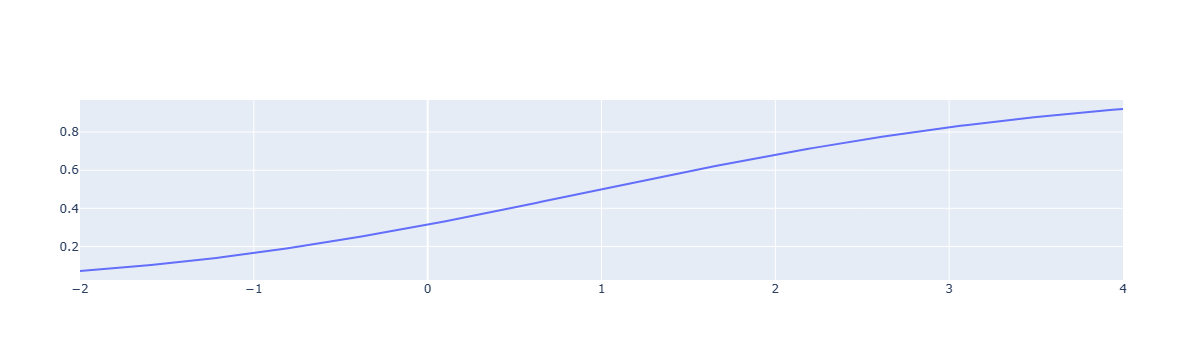

In [120]:
# plot the cdf
X = np.linspace(-2,4,200).tolist() # sample point
fig = go.Figure(data=go.Scatter(x=X, y=[x._cdf(z) for z in X]))
fig.show()